In [44]:
import matplotlib.pyplot as plt
from osgeo import gdal, osr, gdal_array
import json
import numpy as np
import pandas as pd

In [4]:
gt_path = r"E:\Datasets\Spectral Data\Sentinel - La-Guajira-Colombia\SkyFi_24514BEV-1_2024-11-18_1529Z_MULTISPECTRAL_MEDIUM_La-Guajira-Colombia.tif"
gtinfo_path = r"E:\Datasets\Spectral Data\Sentinel - La-Guajira-Colombia\SkyFi_24514BEV-1_2024-11-18_1529Z_MULTISPECTRAL_MEDIUM_La-Guajira-Colombia_metadata.json"
wells_path = r"E:\JGS\Willowstick\Development\Remote Sensing\Guajira Wells\wells and LS new.csv"

In [5]:
with open(gtinfo_path, "r") as f:
    meta = json.load(f)

meta

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': '0835f94e-f4da-4fb6-b19f-16f2ec1f87bc',
 'properties': {'satellite': 'Sentinel-2B',
  'cloud_percentage': 13.003597,
  'capture_time': '2024-11-18T15:29:55',
  'crs': 'EPSG:32618',
  'band_order': ['Coastal_aerosol',
   'B',
   'G',
   'R',
   'Vegetation_red_edge_1',
   'Vegetation_red_edge_2',
   'Vegetation_red_edge_3',
   'NIR',
   'Water_vapour',
   'SWIR_1',
   'SWIR_2',
   'Narrow_NIR'],
  'bands_count': 12,
  'nodata_value': 0,
  'processing_level': 'ORTHO',
  'data_bits': 16,
  'gsd_meters_y': 10,
  'gsd_meters_x': 10,
  'license': 'Contains modified Copernicus Sentinel data 2024. Delivered by SkyFi®',
  'datetime': '2024-11-18T15:29:55Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-72.932102, 11.242217],
    [-71.910067, 11.242217],
    [-71.910067, 12.050584],
    [-72.932102, 12.050584],
    [-72.932102, 11.242217]]]},
 'links': [],
 'assets': {},
 'bbox': [725362.3457678275, 1243560.0, 809752.3457678275, 13000

In [39]:
# wells = np.loadtxt(wells_path, delimiter=",")
wellsdf = pd.read_csv(wells_path)
wells = wellsdf.to_numpy()

In [40]:
def is_point_in_rectangle(lon, lat, rect):
    """
    Check if a point (lat, lon) is inside a rectangle defined by four corner points.
    
    Parameters:
    lat (float): Latitude of the point.
    lon (float): Longitude of the point.
    rect (list): List of four tuples representing the corners of the rectangle in (lat, lon) format.
    
    Returns:
    bool: True if the point is inside the rectangle, False otherwise.
    """
    min_lat = min(rect[0][0], rect[1][0], rect[2][0], rect[3][0])
    max_lat = max(rect[0][0], rect[1][0], rect[2][0], rect[3][0])
    min_lon = min(rect[0][1], rect[1][1], rect[2][1], rect[3][1])
    max_lon = max(rect[0][1], rect[1][1], rect[2][1], rect[3][1])
    
    return (min_lat <= lat <= max_lat) & (min_lon <= lon <= max_lon)

In [41]:
rect_coords = meta["geometry"]["coordinates"][0]
rect_coords

[[-72.932102, 11.242217],
 [-71.910067, 11.242217],
 [-71.910067, 12.050584],
 [-72.932102, 12.050584],
 [-72.932102, 11.242217]]

In [42]:
in_rect = []

for lat, lon, _ in wells:
    in_rect.append(is_point_in_rectangle(lat, lon, rect_coords))


In [82]:
# rasterArray = gdal_array.LoadFile(gt_path)
# rasterArray.Info()
gt = gdal.Open(gt_path)

print(gt.RasterXSize)
print(gt.RasterYSize)
print(gt.RasterCount)

8439
5646
12


In [50]:
print(meta["bbox"][2] - meta["bbox"][0])
print(meta["bbox"][3] - meta["bbox"][1])

84390.0
56460.0


In [104]:
from pyproj import Proj
lon_min = -72.932102
lat_min = 12.050584

p1 = Proj(init="EPSG:32618")
x, y = p1(lon_min, lat_min, inverse=False)

print(x, y, meta["bbox"][0],  meta["bbox"][1])
print(meta["bbox"][0],  meta["bbox"][1])
print(geot[0], geot[3])

725112.3509930989 1332995.5126566358 725362.3457678275 1243560.0
725362.3457678275 1243560.0
725362.3457678275 1300020.0


C:\Users\scott\.conda\envs\gisenv\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [111]:
array_XYs = []
geot = gt.GetGeoTransform()

for lat, lon, _ in wells:
    x, y = p1(lon, lat, inverse=False)

    # array_XYs.append([int((x - meta["bbox"][0]) / 10), int((y - meta["bbox"][1]) / 10)])
    array_XYs.append([int((x - geot[0]) / 10), int((geot[3] - y) / 10)])

array_XYs = np.array(array_XYs)

In [113]:
img = plt.imread(r"E:\Datasets\Spectral Data\Sentinel - La-Guajira-Colombia\SkyFi_24514BEV-1_2024-11-18_1529Z_MULTISPECTRAL_MEDIUM_La-Guajira-Colombia.png")
# img = np.flipud(img)

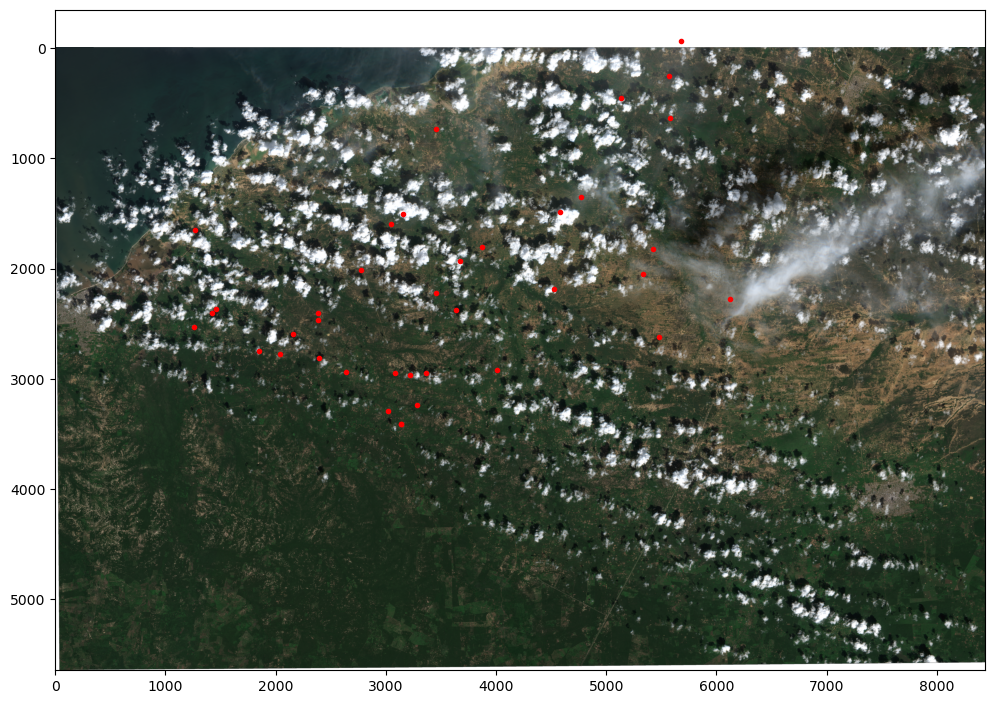

In [115]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(img, origin="upper")
ax.scatter(array_XYs[:, 0], array_XYs[:, 1], c="red", marker=".")

In [135]:
ax, ay = array_XYs[0, 0], array_XYs[0, 1]

bnd = gt.GetRasterBand(1)
NoData = bnd.GetNoDataValue()

nBands = gt.RasterCount
dType = bnd.DataType

print(NoData, nBands, dType)
gt.ReadAsArray(xoff=ax, yoff=ay, xsize=1, ysize=1, band_list=list(range(1,13)))
# atPt = gt.GetLayerCount()


0.0 12 2


array([[[1547]],

       [[2002]],

       [[2484]],

       [[2838]],

       [[2767]],

       [[3719]],

       [[4082]],

       [[4252]],

       [[4387]],

       [[3820]],

       [[3026]],

       [[4234]]], dtype=uint16)